# Message Concealment Scheme

## Libraries and initial setup

In [1]:
!pip3 install gmpy2
!pip install tensorflow

     |████████████████████████████████| 207.1 MB 4.2 MB/s eta 0:00:01 | 49.7 MB 5.2 MB/s eta 0:00:31     |████████████████████████▊       | 159.7 MB 3.8 MB/s eta 0:00:13     |███████████████████████████▊    | 179.7 MB 6.4 MB/s eta 0:00:05
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 1.6 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 3.3 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached astunparse-1.6.3-py2.p

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import ctypes
import gmpy2
from gmpy2 import mpz


%matplotlib inline

In [ ]:
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.engine.input_layer import Input
from tensorflow.keras.layers.core import Activation, Dense
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers.convolutional import Conv1D
from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

In [5]:
# Set up the crypto parameters: message, key, and ciphertext bit lengths
m_bits = 16
k_bits = 16
c_bits = 16
pad = 'same'

## Model Building

### Alice

In [6]:
ainput0 = Input(shape=(m_bits,)) #message
ainput1 = Input(shape=(k_bits,)) #key
ainput = concatenate([ainput0, ainput1], axis=1)

adense1 = Dense(units=(m_bits + k_bits))(ainput)
adense1a = Activation('relu')(adense1)
areshape = Reshape((m_bits + k_bits, 1,))(adense1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(areshape)
aconv1a = Activation('sigmoid')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('sigmoid')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('sigmoid')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('tanh')(aconv4)

aoutput = Flatten()(aconv4a)

alice = Model([ainput0, ainput1], aoutput, name='alice')
alice.summary()


NameError: name 'Input' is not defined

### Bob

In [113]:
binput0 = Input(shape=(c_bits,)) #ciphertext
binput1 = Input(shape=(k_bits,)) #key
binput = concatenate([binput0, binput1], axis=1)

bdense1 = Dense(units=(c_bits + k_bits))(binput)
bdense1a = Activation('relu')(bdense1)

breshape = Reshape((c_bits + k_bits, 1,))(bdense1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(breshape)
bconv1a = Activation('sigmoid')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('sigmoid')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('sigmoid')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('tanh')(bconv4)

boutput = Flatten()(bconv4a)

bob = Model([binput0, binput1], boutput, name='bob')

# bob.summary()

### Eve

In [123]:
einput = Input(shape=(c_bits,)) #ciphertext only

edense1 = Dense(units=(c_bits + k_bits))(einput)
edense1a = Activation('relu')(edense1)

edense2 = Dense(units=(c_bits + k_bits))(edense1a)
edense2a = Activation('relu')(edense2)

ereshape = Reshape((c_bits + k_bits, 1,))(edense2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(ereshape)
econv1a = Activation('sigmoid')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('sigmoid')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('sigmoid')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('tanh')(econv4)

eoutput = Flatten()(econv4a)# Eve's attempt at code guessing

eve = Model(einput, eoutput, name='eve')

eve.summary()

In [124]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

## Loss Functions and Optimizers

In [116]:
m_train = 2**(m_bits) #+ k_bits)

In [117]:
# Establish the communication channels by linking inputs to outputs
#
aliceout = alice([ainput0, ainput1])
bobout = bob( [aliceout, binput1] )# bob sees ciphertext AND key
eveout = eve( aliceout )# eve doesn't see the key, only the cipher

# Loss for Eve is just L1 distance between ainput0 and eoutput. The sum
# is taken over all the bits in the message. The quantity inside the K.mean()
# is per-example loss. We take the average across the entire mini-batch
#
eveloss = K.mean(  K.sum(K.abs(ainput0 - eveout), axis=-1)  )

# Loss for Alice-Bob communication depends on Bob's reconstruction, but
# also on Eve's ability to decrypt the message. Eve should do no better
# than random guessing, so on average she will guess half the bits right.
#
bobloss = K.mean(  K.sum(K.abs(ainput0 - bobout), axis=-1)  )
abeloss = bobloss + K.square(m_bits/2 - eveloss)/( (m_bits//2)**2 )

# Optimizer and compilation
#
abeoptim = RMSprop(lr=0.001)
eveoptim = RMSprop(lr=0.001) #default 0.001


# Build and compile the ABE model, used for training Alice-Bob networks
#
abemodel = Model([ainput0, ainput1, binput1], bobout, name='abemodel')
abemodel.add_loss(abeloss)
abemodel.compile(optimizer=abeoptim)


# Build and compile the EVE model, used for training Eve net (with Alice frozen)
#
alice.trainable = False
evemodel = Model([ainput0, ainput1], eveout, name='evemodel')
evemodel.add_loss(eveloss)
evemodel.compile(optimizer=eveoptim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Training and Dump

In [118]:
abelosses = []
boblosses = []
evelosses = []

In [119]:
n_epochs = 50
batch_size = 512
n_batches = m_train // batch_size

abecycles = 1
evecycles = 2

epoch = 0
print("Training for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    abelosses0 = []
    boblosses0 = []
    evelosses0 = []
    for iteration in range(n_batches):
        
        # Train the A-B+E network
        #
        alice.trainable = True
        for cycle in range(abecycles):
            # Select a random batch of messages, and a random batch of keys
            #
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = abemodel.train_on_batch([m_batch, k_batch, k_batch], None)
        
        abelosses0.append(loss)
        abelosses.append(loss)
        abeavg = np.mean(abelosses0)
            
        # Evaluate Bob's ability to decrypt a message
        m_enc = alice.predict([m_batch, k_batch])
        m_dec = bob.predict([m_enc, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - m_dec), axis=-1)  )
        boblosses0.append(loss)
        boblosses.append(loss)
        bobavg = np.mean(boblosses0)
        
        # Train the EVE network
        #
        alice.trainable = False
        for cycle in range(evecycles):
            m_batch = np.random.randint(0, 2, m_bits * batch_size).reshape(batch_size, m_bits)
            k_batch = np.random.randint(0, 2, k_bits * batch_size).reshape(batch_size, k_bits)
            loss = evemodel.train_on_batch([m_batch, k_batch], None)
        
        evelosses0.append(loss)
        evelosses.append(loss)
        eveavg = np.mean(evelosses0)
        
        if iteration % max(1, (n_batches // 100)) == 0:
            print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                epoch, 100 * iteration // n_batches, abeavg, eveavg, bobavg), end="")
            sys.stdout.flush()
    
    print()
    epoch += 1
    
print('Training finished.')

Training for 50 epochs with 128 batches of size 512
Epoch   0:  99% | abe: 21.885 | eve: 11.973 | bob: 21.276
Epoch   1:  99% | abe: 16.326 | eve: 8.009 | bob: 16.278
Epoch   2:  99% | abe: 9.845 | eve: 7.997 | bob: 9.806
Epoch   3:  99% | abe: 8.000 | eve: 8.001 | bob: 8.000
Epoch   4:  99% | abe: 7.996 | eve: 8.000 | bob: 7.995
Epoch   5:  99% | abe: 8.002 | eve: 7.999 | bob: 8.001
Epoch   6:  99% | abe: 7.945 | eve: 7.979 | bob: 7.943
Epoch   7:  99% | abe: 7.541 | eve: 7.891 | bob: 7.534
Epoch   8:  99% | abe: 6.698 | eve: 7.608 | bob: 6.685
Epoch   9:  99% | abe: 5.609 | eve: 7.147 | bob: 5.584
Epoch  10:  99% | abe: 4.526 | eve: 6.581 | bob: 4.479
Epoch  11:  99% | abe: 3.622 | eve: 5.871 | bob: 3.536
Epoch  12:  99% | abe: 2.887 | eve: 5.133 | bob: 2.742
Epoch  13:  99% | abe: 2.279 | eve: 4.288 | bob: 2.050
Epoch  14:  99% | abe: 1.827 | eve: 3.416 | bob: 1.488
Epoch  15:  99% | abe: 1.555 | eve: 2.701 | bob: 1.108
Epoch  16:  99% | abe: 1.436 | eve: 2.162 | bob: 0.898
Epoch  1

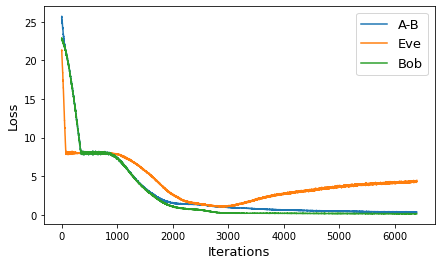

In [125]:
steps = -1

plt.figure(figsize=(7, 4))
plt.plot(abelosses[:steps], label='A-B')
plt.plot(evelosses[:steps], label='Eve')
plt.plot(boblosses[:steps], label='Bob')
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.legend(fontsize=13)

#plt.savefig("images/" + model_name + ".png", transparent=True) #dpi=100
plt.show()

### Saving

In [121]:
if False: #Don't overwrite by accidentMB
    alice.save(alice_file + '.h5', overwrite=True)
    bob.save(bob_file + '.h5', overwrite=True)
    eve.save(eve_file + '.h5', overwrite=True)

## Evaluate

In [122]:
n_examples = 10000

m_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)
k_batch = np.random.randint(0, 2, m_bits * n_examples).reshape(n_examples, m_bits)

m_enc = alice.predict([m_batch, k_batch])
m_dec = (bob.predict([m_enc, k_batch]) > 0.5).astype(int)
m_att = (eve.predict(m_enc) > 0.5).astype(int)

bdiff = np.abs(m_batch - m_dec)
bsum = np.sum(bdiff, axis=-1)
ediff = np.abs(m_batch - m_att)
esum = np.sum(ediff, axis=-1)

print("Bob % correct: ", 100.0*np.sum(bsum == 0) / n_examples, '%')
print("Eve % correct: ", 100.0*np.sum(esum == 0) / n_examples, '%')

Bob % correct:  99.71 %
Eve % correct:  0.58 %


Make Epochs 50 for better visualization